In [ ]:
# install new code

In [ ]:
# install https://github.com/xarray-contrib/xskillscore/pull/277 PR with fixed RPS
!pip install git+https://github.com/xarray-contrib/xskillscore.git@refs/pull/277/head

In [ ]:
# install https://github.com/pangeo-data/climpred/pull/566 PR with climatology
!pip install git+https://github.com/pangeo-data/climpred.git@refs/pull/566/head

In [3]:
import cftime
import numpy as np
import xarray as xr
import climpred
import glob
from tqdm import tqdm
import dask.array as da
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

import xskillscore as xs

climpred.__version__, xs.__version__

('2.1.2.post23', '0.0.18.post138')

In [4]:
#client = Client()

In [5]:
verifdata = "CPC" #can be ERA5 or CPC
#domain = "global"
domain = "North America"
metric = "rps" #can be rps, crps, crpss, rmse, acc
if metric == "acc" or metric=="rmse":
    comp="e2o"
    dim="init"
else:
    comp="m2o"
    dim=["init","member"]
v='TAS'

In [6]:
hinda2 = xr.open_zarr(f"/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
hinda1 = xr.open_zarr(f"/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM1.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
hindaw = xr.open_zarr(f"/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
verif = xr.open_zarr(f"/glade/campaign/cesm/development/cross-wg/S2S/jaye/{verifdata}.tas.zarr/", consolidated=True)
land = xr.open_dataset("/glade/work/jaye/landsea.nc")

In [7]:
# converting to a proleptic gregorian calendar since the observations
# have leap years. you could also just drop the leap year days from
# the obs.
hinda2["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda2["init"].values]
hinda1["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda1["init"].values]
hindaw["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hindaw["init"].values]

In [119]:
#hinda2.sel(lat=slice(15.0, 75.0),lon=slice(190.0, 305.0))[v].sel(member=slice(0,4)).mean(['lon','lat']).plot(x='init',col='lead',hue='member')

In [85]:
hind=xr.concat([hinda2.drop('dayofyear'),hinda1.drop('dayofyear'), hindaw.drop('dayofyear')], dim='model')
hind['model']=['CESM2','CESM1','WACCM']

In [86]:
hind["lead"].attrs["units"] = "weeks"

In [102]:
hinda2.init

<xarray.DataArray 'init' (init: 1095)>
array([cftime.DatetimeProlepticGregorian(1999, 1, 4, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1999, 1, 11, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1999, 1, 18, 0, 0, 0, 0), ...,
       cftime.DatetimeProlepticGregorian(2019, 12, 16, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2019, 12, 23, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2019, 12, 30, 0, 0, 0, 0)],
      dtype=object)
Coordinates:
    dayofyear  (init) int64 dask.array<chunksize=(365,), meta=np.ndarray>
  * init       (init) object 1999-01-04 00:00:00 ... 2019-12-30 00:00:00

In [104]:
hindaw.init

<xarray.DataArray 'init' (init: 655)>
array([cftime.DatetimeProlepticGregorian(1999, 1, 4, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1999, 1, 11, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1999, 1, 18, 0, 0, 0, 0), ...,
       cftime.DatetimeProlepticGregorian(2020, 10, 12, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2020, 10, 19, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2020, 10, 26, 0, 0, 0, 0)],
      dtype=object)
Coordinates:
    dayofyear  (init) int64 dask.array<chunksize=(211,), meta=np.ndarray>
  * init       (init) object 1999-01-04 00:00:00 ... 2020-10-26 00:00:00

In [103]:
hinda1.init

<xarray.DataArray 'init' (init: 887)>
array([cftime.DatetimeProlepticGregorian(1999, 1, 6, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1999, 1, 13, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1999, 1, 20, 0, 0, 0, 0), ...,
       cftime.DatetimeProlepticGregorian(2015, 12, 16, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2015, 12, 23, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2015, 12, 30, 0, 0, 0, 0)],
      dtype=object)
Coordinates:
    dayofyear  (init) int64 dask.array<chunksize=(365,), meta=np.ndarray>
  * init       (init) object 1999-01-06 00:00:00 ... 2015-12-30 00:00:00

In [ ]:
# Convert our verification product to the same calendar type.
# Climpred just needs to see the same datetime object styles for
# alignment. You could use numpy datestrings or pandas on both,
# cftime.noleap or gregorian, etc.
def convert_to_cftime(x):
    x = str(x)
    y, m, d = x.split("-")
    y = int(y)
    m = int(m)
    d = int(d.split("T")[0])
    return cftime.DatetimeProlepticGregorian(y, m, d)


verif["time"] = [convert_to_cftime(t) for t in verif.time.values]

In [11]:
#Weird stuff in new zealand happening. This is easiest way to fix that i have found.
if verifdata=="CPC":
    verif = verif.where(-100<verif.TAS)
    verif = verif.where(100>verif.TAS)

In [12]:
# have to broadcast model dimension yourself, but eventually climpred should do this
# https://github.com/pangeo-data/climpred/issues/528
verif=xr.concat([verif]*3,'model').drop('dayofyear')
verif['model']=hind.model

In [105]:
hindcast = climpred.HindcastEnsemble(hind).add_observations(verif)

In [107]:
hindcast = hindcast.sel(init=slice("1999-01-01", "2015-12-31"))

In [90]:
if domain == 'North America':
    hindcast = hindcast.sel(lat=slice(15.0, 75.0),lon=slice(190.0, 305.0))

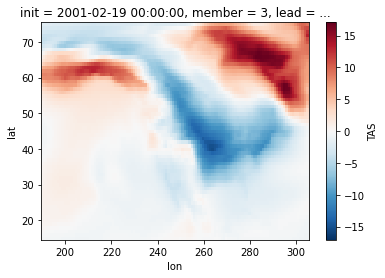

In [91]:
# sea not masked
hindcast.isel(init=222,member=2,model=2,lead=2).get_initialized()[v].plot()

In [92]:
#hindcast.where(land.LSMASK==1)

In [93]:
#hinda2 = hinda2.where(hinda2.mask==1)
#hinda1 = hinda1.where(hinda1.mask==1)
#hindaw = hindaw.where(hindaw.mask==1)
#verif = verif.where(verif.mask==1)

In [94]:
#hindcast = hindcast.chunk({"lat": 36, "lon": 72}).chunk({'time':-1}).chunk({"member": -1, "init": -1, "lead": "auto"}).persist()

In [95]:
hindcast = hindcast.sel(member = slice(0,4))

In [96]:
hindcast_djf = hindcast.sel(init=hindcast.get_initialized().init.dt.season=='DJF').sel(
    time=hindcast.get_observations().time.dt.season=='DJF')

# North America mean

In [120]:
# simple North America mean                         # very important to drop empty inits from other model
hindcast2_djf_mean = hindcast_djf.sel(model='CESM2',drop=True).dropna('init').mean(['lon','lat']).compute()

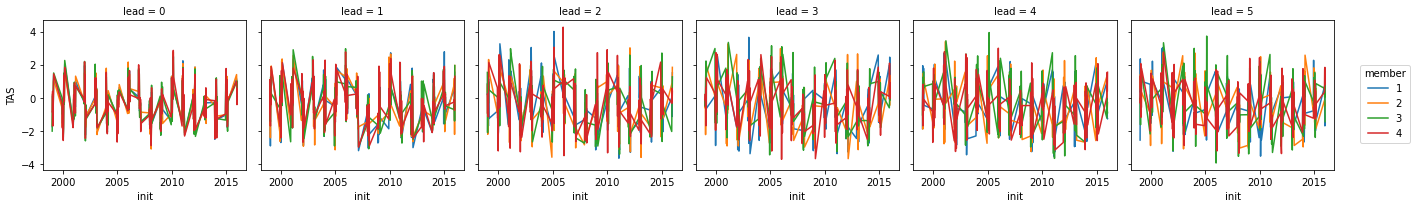

In [121]:
hindcast2_djf_mean.get_initialized()[v].plot(x='init',col='lead',hue='member')

<AxesSubplot:xlabel='time', ylabel='TAS'>

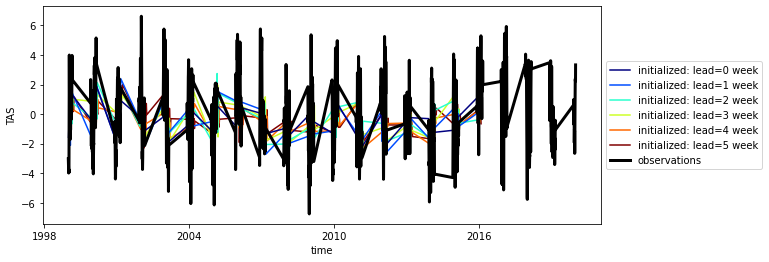

In [122]:
hindcast2_djf_mean.plot()

In [123]:
# create bins with xs helper function for quantiles
obs_bins = xs.core.utils.quantile_edges_pad_lower_upper(hindcast2_djf_mean.get_observations(),
                                                        edges=[.33,.66],lower=-np.inf, upper=np.inf, dim=['time'])

In [124]:
forecast_bins = xs.core.utils.quantile_edges_pad_lower_upper(hindcast2_djf_mean.get_initialized(),
                                                             edges=[.33,.66],lower=-np.inf, upper=np.inf, dim=['init','member','lead'])

Text(0.5, 1.0, 'Forecast distribution')

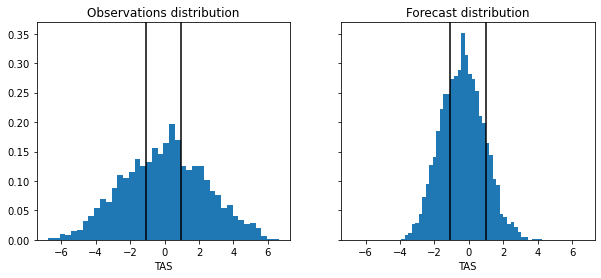

In [125]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(10,4),sharex=True, sharey=True)
hindcast2_djf_mean.get_observations()[v].plot.hist(bins=40,ax=ax[0], density=True)
for e in obs_bins.category_edge[1:-1]:
    ax[0].axvline(x=obs_bins.sel(category_edge=e).TAS,c='k')
    
ax[0].set_title('Observations distribution')
hindcast2_djf_mean.get_initialized()[v].plot.hist(bins=40,ax=ax[1], density=True)
for e in forecast_bins.category_edge[1:-1]:
    ax[1].axvline(x=obs_bins.sel(category_edge=e).TAS,c='k')
ax[1].set_title('Forecast distribution')

In [126]:
skill = hindcast2_djf_mean.verify(metric="rps", alignment="maximize", comparison=comp,
                                  dim=dim,reference=['climatology','persistence'],
                                  category_edges=(obs_bins,forecast_bins))

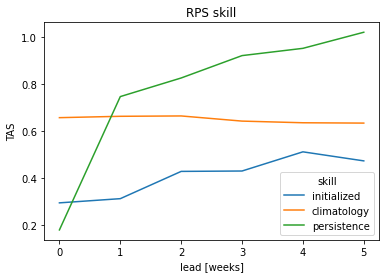

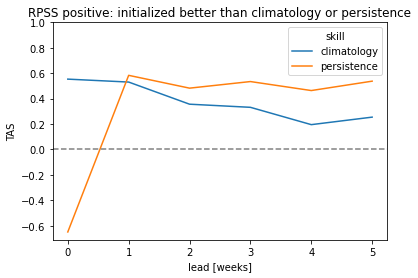

In [127]:
skill[v].plot(hue='skill')
plt.title('RPS skill')
plt.show()

# RPSS with respect to climatology or persistence
rpss = 1 - skill.sel(skill='initialized')/skill.drop_sel(skill='initialized')
rpss[v].plot(hue='skill')
plt.axhline(y=0,c='gray',ls='--')
plt.ylim([None,1])
plt.title('RPSS positive: initialized better than climatology or persistence')
plt.show()

## after bias reduction

In [134]:
hindcast2_djf_mean_bias_removed = hindcast2_djf_mean.drop('dayofyear').remove_bias(alignment="maximize")

In [129]:
assert 'dayofyear' not in hindcast2_djf_mean_bias_removed.get_initialized().dims  # have to fix that

AssertionError: 

In [ ]:
# create bins with xs helper function for quantiles
obs_bins = xs.core.utils.quantile_edges_pad_lower_upper(hindcast2_djf_mean_bias_removed.get_observations(), edges=[.33,.66],lower=-np.inf, upper=np.inf,dim=['time'])
forecast_bins = xs.core.utils.quantile_edges_pad_lower_upper(hindcast2_djf_mean_bias_removed.get_initialized(), edges=[.33,.66],lower=-np.inf, upper=np.inf,dim=['init','member','lead'])

In [84]:
skill = hindcast2_djf_mean_bias_removed.verify(metric="rps",alignment="maximize",comparison=comp,dim=dim,reference=['climatology','persistence'],category_edges=(obs_bins,forecast_bins))

In [ ]:
skill[v].plot(hue='skill')
plt.title('RPS skill')
plt.show()

# RPSS with respect to climatology or persistence
rpss = 1 - skill.sel(skill='initialized')/skill.drop_sel(skill='initialized')
rpss[v].plot(hue='skill')
plt.axhline(y=0,c='gray',ls='--')
plt.ylim([None,1])
plt.title('RPSS with respect to climatology or persistence reference skill')

# North America map

In [133]:
hindcast2_djf = hindcast_djf.sel(model='CESM2',drop=True).dropna('init')

In [139]:
# create bins with xs helper function for quantiles
b=50.
obs_bins = xs.core.utils.quantile_edges_pad_lower_upper(hindcast2_djf.get_observations().chunk({'time':-1}),
                                                        edges=[.33,.66],lower=-b, upper=b, dim=['time'])
forecast_bins = xs.core.utils.quantile_edges_pad_lower_upper(hindcast2_djf.get_initialized().chunk({'init':-1,'lead':-1}),
                                                             edges=[.33,.66],lower=-b, upper=b, dim=['init','member','lead'])

In [140]:
%%time
skill = hindcast2_djf.verify(metric="rps", alignment="maximize", comparison=comp, dim=dim,
                             reference='climatology', category_edges=(obs_bins,forecast_bins))

CPU times: user 23min 50s, sys: 12min 35s, total: 36min 25s
Wall time: 25min 26s


In [141]:
%time skill = skill.compute()

CPU times: user 2min 30s, sys: 32.4 s, total: 3min 2s
Wall time: 3min 4s


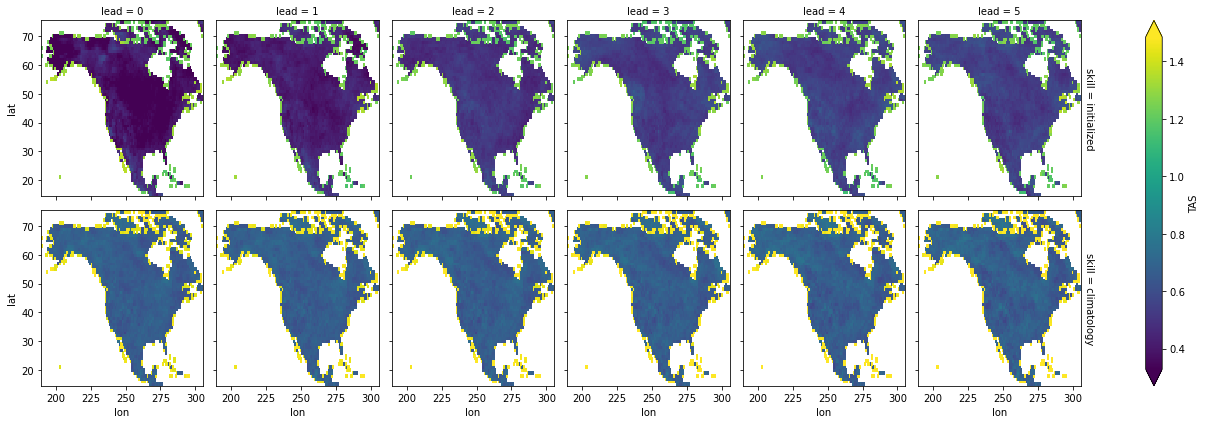

In [142]:
skill[v].plot(col='lead',row='skill', robust=True)

In [143]:
rpss = 1 - skill.sel(skill='initialized')/skill.drop_sel(skill='initialized')

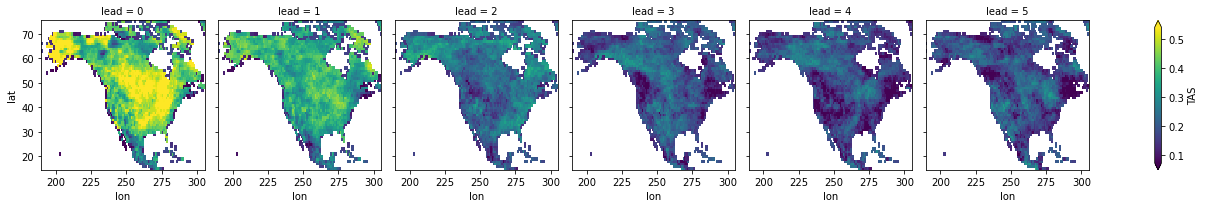

In [144]:
rpss[v].plot(col='lead', robust=True)

In [145]:
skill.to_netcdf('rps.nc')

In [ ]:
# Will imeplemnt here later (Abby's code)
if metric=="rps":

    category_edges=verif_djf.quantile(q=[.33,.66], dim=['time'])
    
    
    rpsw_djf = hindcastw_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps1_djf = hindcast1_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps2_djf = hindcast2_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps1_5_djf = hindcast1_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps2_5_djf = hindcast2_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    
    rps2_djf = hindcast2_djf.verify(metric=__rps, comparison=comp, dim=['init','member'], alignment='maximize',category_edges)
    
    rps1_jja = hindcast1_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps2_jja = hindcast2_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps1_5_jja = hindcast1_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
    rps2_5_jja = hindcast2_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=bins)
else:
    rpsw_djf = hindcastw_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_djf = hindcast1_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_djf = hindcast2_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_5_djf = hindcast1_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_5_djf = hindcast2_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_jja = hindcast1_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_jja = hindcast2_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_5_jja = hindcast1_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_5_jja = hindcast2_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')

In [ ]:
rps2_djf = hindcast2_djf.verify(metric=__rps, comparison=comp, dim=['init','member'], alignment='maximize', category_edges=verif_djf.quantile(q=[.33,.66], dim=['time']))

In [ ]:
if metric=="rps":
    rpsw_djf = rpsw_djf.where(hindaw.mask==1)
    rps1_djf = rps1_djf.where(hindaw.mask==1)
    rps2_djf = rps2_djf.where(hindaw.mask==1)
    rps1_5_djf = rps1_5_djf.where(hindaw.mask==1)
    rps2_5_djf = rps2_5_djf.where(hindaw.mask==1)
    rps1_jja = rps1_jja.where(hindaw.mask==1)
    rps2_jja = rps2_jja.where(hindaw.mask==1)
    rps1_5_jja = rps1_5_jja.where(hindaw.mask==1)
    rps2_5_jja = rps2_5_jja.where(hindaw.mask==1)
    

In [ ]:
#rps2_djf.TAS.plot(col='lead')
#rps1_jja.TAS.sel(lead=slice(2,3)).mean("lead").plot()

In [ ]:
rpsw_djf_aw = rpsw_djf.weighted(np.cos(np.deg2rad(rpsw_djf.lat))).mean(("lat","lon")).persist()
rps1_djf_aw = rps1_djf.weighted(np.cos(np.deg2rad(rps1_djf.lat))).mean(("lat","lon")).persist()
rps2_djf_aw = rps2_djf.weighted(np.cos(np.deg2rad(rps2_djf.lat))).mean(("lat","lon")).persist()
rps1_5_djf_aw = rps1_5_djf.weighted(np.cos(np.deg2rad(rps1_5_djf.lat))).mean(("lat","lon")).persist()
rps2_5_djf_aw = rps2_5_djf.weighted(np.cos(np.deg2rad(rps2_5_djf.lat))).mean(("lat","lon")).persist()
rps1_jja_aw = rps1_jja.weighted(np.cos(np.deg2rad(rps1_djf.lat))).mean(("lat","lon")).persist()
rps2_jja_aw = rps2_jja.weighted(np.cos(np.deg2rad(rps2_djf.lat))).mean(("lat","lon")).persist()
rps1_5_jja_aw = rps1_5_jja.weighted(np.cos(np.deg2rad(rps1_5_djf.lat))).mean(("lat","lon")).persist()
rps2_5_jja_aw = rps2_5_jja.weighted(np.cos(np.deg2rad(rps2_5_djf.lat))).mean(("lat","lon")).persist()

In [ ]:
#Ensemble spread
#hinda2_djf.TAS.std("member").mean(("lat","lon")).mean("init").plot()

In [ ]:
#Ensemble mean if metric = 'RMSE"'
rps2_djf.TAS.mean(("lat", "lon")).plot()

In [ ]:
barWidth = 0.15
barsw = [rpsw_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rpsw_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rpsw_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
rw = np.arange(len(barsw))
bars2_5 = [rps2_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
           rps2_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
           rps2_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2_5 = [x + barWidth + 0.025 for x in rw]
bars2 = [rps2_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rps2_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rps2_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2 = [x + barWidth + 0.025 for x in r2_5]
bars1_5 = [rps1_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
           rps1_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
           rps1_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1_5 = [x + barWidth + 0.025 for x in r2]
bars1 = [rps1_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rps1_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rps1_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1 = [x + barWidth + 0.025 for x in r1_5]

In [ ]:
plt.bar(rw, barsw, width = barWidth, color = "#2f70b7", edgecolor="white", label="CESM2-WACCM(5)")
plt.bar(r2_5, bars2_5, width = barWidth, color = "#d1a3ac", edgecolor="white", label="CESM2-CAM(5)")
plt.bar(r2, bars2, width = barWidth, color = "#942532", edgecolor="white", label="CESM2-CAM(10)")
plt.bar(r1_5, bars1_5, width = barWidth, color = "#c9e4a9", edgecolor="white", label="CESM1-CAM(5)")
plt.bar(r1, bars1, width = barWidth, color = "#7cbd3f", edgecolor="white", label="CESM1-CAM(10)")
plt.xticks([r + barWidth + 0.2 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"])
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,10.0) #for rmse
plt.ylabel(metric.upper())
plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (DJF) - "+verifdata)
plt.legend(borderaxespad=0.6,edgecolor="black")
if domain == "North America":
    plt.savefig(metric+"_NAland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    plt.savefig(metric+"_globalland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

In [ ]:
barWidth = 0.175
bars2_5 = [rps2_5_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
           rps2_5_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
           rps2_5_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
r2_5 = np.arange(len(bars2_5))
bars2 = [rps2_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
         rps2_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
         rps2_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
r2 = [x + barWidth + 0.025 for x in r2_5]
bars1_5 = [rps1_5_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
           rps1_5_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
           rps1_5_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
r1_5 = [x + barWidth + 0.025 for x in r2]
bars1 = [rps1_jja_aw.TAS.sel(lead=slice(0,1)).mean("lead").persist(),
         rps1_jja_aw.TAS.sel(lead=slice(2,3)).mean("lead").persist(),
         rps1_jja_aw.TAS.sel(lead=slice(4,5)).mean("lead").persist()]
r1 = [x + barWidth + 0.025 for x in r1_5]

In [ ]:
plt.bar(r2_5, bars2_5, width = barWidth, color = "#d1a3ac", edgecolor="white", label="CESM2-CAM(5)")
plt.bar(r2, bars2, width = barWidth, color = "#942532", edgecolor="white", label="CESM2-CAM(10)")
plt.bar(r1_5, bars1_5, width = barWidth, color = "#c9e4a9", edgecolor="white", label="CESM1-CAM(5)")
plt.bar(r1, bars1, width = barWidth, color = "#7cbd3f", edgecolor="white", label="CESM1-CAM(10)")
plt.xticks([r + barWidth + 0.2 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"])
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,10.0) #for rmse
plt.ylabel(metric.upper())
plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (JJA) - "+verifdata)
plt.legend(borderaxespad=0.6,edgecolor="black")
if domain == "North America":
    plt.savefig(metric+"_NAland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    plt.savefig(metric+"_globalland_JJA_"+verifdata+".jpg",dpi=300,bbox_inches="tight")

Bar plots for with both ensemble spread and rmse

In [ ]:
ensprw_djf

In [ ]:
barWidth = 0.075
barsw = [rpsw_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rpsw_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rpsw_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
rw = np.arange(len(barsw))
barsw_s = [ensprw_djf.sel(lead=slice(0,1)).mean("lead").compute(),
           ensprw_djf.sel(lead=slice(2,3)).mean("lead").compute(),
           ensprw_djf.sel(lead=slice(4,5)).mean("lead").compute()]
rw_s = [x + barWidth + 0.025 for x in rw]
bars2_5 = [rps2_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
           rps2_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
           rps2_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2_5 = [x + barWidth + 0.025 for x in rw_s]
bars2_5_s = [enspr2_5_djf.sel(lead=slice(0,1)).mean("lead").compute(),
           enspr2_5_djf.sel(lead=slice(2,3)).mean("lead").compute(),
           enspr2_5_djf.sel(lead=slice(4,5)).mean("lead").compute()]
r2_5_s = [x + barWidth + 0.025 for x in r2_5]
bars2 = [rps2_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rps2_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rps2_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r2 = [x + barWidth + 0.025 for x in r2_5_s]
bars2_s = [enspr2_djf.sel(lead=slice(0,1)).mean("lead").compute(),
           enspr2_djf.sel(lead=slice(2,3)).mean("lead").compute(),
           enspr2_djf.sel(lead=slice(4,5)).mean("lead").compute()]
r2_s = [x + barWidth + 0.025 for x in r2]
bars1_5 = [rps1_5_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
           rps1_5_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
           rps1_5_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1_5 = [x + barWidth + 0.025 for x in r2_s]
bars1_5_s = [enspr1_5_djf.sel(lead=slice(0,1)).mean("lead").compute(),
             enspr1_5_djf.sel(lead=slice(2,3)).mean("lead").compute(),
             enspr1_5_djf.sel(lead=slice(4,5)).mean("lead").compute()]
r1_5_s = [x + barWidth + 0.025 for x in r1_5]
bars1 = [rps1_djf_aw.TAS.sel(lead=slice(0,1)).mean("lead").compute(),
         rps1_djf_aw.TAS.sel(lead=slice(2,3)).mean("lead").compute(),
         rps1_djf_aw.TAS.sel(lead=slice(4,5)).mean("lead").compute()]
r1 = [x + barWidth + 0.025 for x in r1_5_s]
bars1_s = [enspr1_djf.sel(lead=slice(0,1)).mean("lead").compute(),
           enspr1_djf.sel(lead=slice(2,3)).mean("lead").compute(),
           enspr1_djf.sel(lead=slice(4,5)).mean("lead").compute()]
r1_s = [x + barWidth + 0.025 for x in r1]

In [ ]:
plt.bar(rw, barsw, width = barWidth, color = "#2f70b7", edgecolor="white", label="CESM2-WACCM(5)")
plt.bar(rw_s, barsw_s, width = barWidth, color = "#2f70b7", edgecolor="white", hatch="///")
plt.bar(r2_5, bars2_5, width = barWidth, color = "#d1a3ac", edgecolor="white", label="CESM2-CAM(5)")
plt.bar(r2_5_s, bars2_5_s, width = barWidth, color = "#d1a3ac", edgecolor="white", hatch="/")
plt.bar(r2, bars2, width = barWidth, color = "#942532", edgecolor="white", label="CESM2-CAM(10)")
plt.bar(r2_s, bars2_s, width = barWidth, color = "#942532", edgecolor="white", hatch="/")
plt.bar(r1_5, bars1_5, width = barWidth, color = "#c9e4a9", edgecolor="white", label="CESM1-CAM(5)")
plt.bar(r1_5_s, bars1_5_s, width = barWidth, color = "#c9e4a9", edgecolor="white", hatch="/")
plt.bar(r1, bars1, width = barWidth, color = "#7cbd3f", edgecolor="white", label="CESM1-CAM(10)")
plt.bar(r1_s, bars1_s, width = barWidth, color = "#7cbd3f", edgecolor="white", hatch="/")
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"])
plt.tick_params(axis = "y", direction = "in", which = "both")
plt.tick_params(axis = "y", which = "minor", left = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
if metric=="acc":
    y_locator = FixedLocator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) #for rps and acc
    plt.gca().yaxis.set_major_locator(y_locator) #for rps and acc
    plt.ylim(0,1.0) #for rps and acc
elif metric=="rps":
    plt.ylim(0,1.5)
elif metric=="crpss":
    plt.ylim(-0.3,0.1) #for crpss
elif metric=="crps":
    plt.ylim(0,6.0) #for crps
elif metric=="rmse":
    plt.ylim(0,10.0) #for rmse
plt.ylabel(metric.upper())
plt.title("2m Temperature "+metric.upper()+" for "+domain+" land (DJF) - "+verifdata)
plt.legend(borderaxespad=0.6,edgecolor="black")
if domain == "North America":
    plt.savefig(metric+"_NAland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")
elif domain == "global":
    plt.savefig(metric+"_globalland_DJF_"+verifdata+".jpg",dpi=300,bbox_inches="tight")